In [29]:
%pip install numpy
%pip install matplotlib
%pip install qiskit
%pip install qiskit-aer


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [30]:
import numpy as np

In [31]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

In [32]:
### --- Configuração ---
np.random.seed(42)
NUM_BITS = 8

## Protocolo sem Espião

### Parte 1 - Setup

In [33]:
# --- Geração de sequências aleatórias para Alice ---
alice_bits  = np.random.randint(2, size=NUM_BITS)
alice_bases = np.random.randint(2, size=NUM_BITS) # 0 para base Z (+), 1 para base X (x)

In [34]:
base_processing_function = lambda b: "+" if b == 0 else "x"
base_processing = np.vectorize(base_processing_function)

In [35]:
print(f"Bits de Alice:\t{alice_bits}")
print(f"Bases de Alice:\t{base_processing(alice_bases)}")

Bits de Alice:	[0 1 0 0 0 1 0 0]
Bases de Alice:	['+' 'x' '+' '+' '+' '+' 'x' '+']


In [36]:
# --- Geração de bases aleatórias para Bob ---
bob_bases = np.random.randint(2, size=NUM_BITS)

In [37]:
print(f"Bases de Bob:\t{base_processing(bob_bases)}")

Bases de Bob:	['x' 'x' 'x' '+' 'x' '+' 'x' 'x']


### Parte 2 - Circuito

In [38]:
def create_bb84_circuit(
    bits: list[int],
    sender_bases: list[str],
    measurement_bases: list[str]
) -> list[QuantumCircuit]:
    """Cria um circuito para cada bit do protocolo BB84"""
    circuits = []
    num_bits = len(bits)

    for i in range(num_bits):
        qc = QuantumCircuit(1, 1, name=f"qubit_{i}")

        # --- Preparação por Alice ---
        # Se o bit de Alice é 1, aplica a porta X
        if bits[i] == 1:
            qc.x(0)
        # Se a base de Alice é X, aplica Hadamard
        if sender_bases[i] == 1:
            qc.h(0)
        
        qc.barrier()

        # --- Medição por Bob ---
        # Se a base de Bob é X, aplica Hadamard
        if measurement_bases[i] == 1:
            qc.h(0)
        
        qc.measure(0, 0)
        circuits.append(qc)

    return circuits

In [39]:
bb84_circuits = create_bb84_circuit(alice_bits, alice_bases, bob_bases)

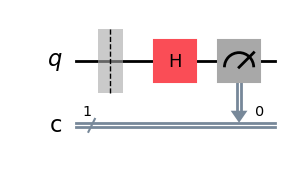

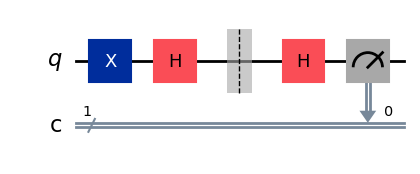

In [40]:
display(bb84_circuits[0].draw("mpl"))
display(bb84_circuits[1].draw("mpl"))

### Parte 3 - Simulação

In [41]:
simulator = AerSimulator()

In [42]:
bob_bits = []

for qc in bb84_circuits:
    # Executa cada circuito uma única vez, pois é um processo determinístico
    job = simulator.run(qc, shots=1, memory=True)
    result = job.result()
    measurement = int("".join(result.get_memory()))
    bob_bits.append(measurement)

print(f"Bits de Bob:\t{np.array(bob_bits)}")

Bits de Bob:	[1 1 1 0 1 1 0 1]


In [43]:
# Alice e Bob comparam as bases
alice_sifted_key = []
bob_sifted_key   = []

In [44]:
for i in range(NUM_BITS):
    if alice_bases[i] == bob_bases[i]:
        alice_sifted_key.append(int(alice_bits[i]))
        bob_sifted_key.append(int(bob_bits[i]))

In [45]:
same_base_idx = [i for i, (b1, b2) in enumerate(zip(alice_bases, bob_bases)) if b1 == b2]

In [46]:
print("\n--- Pós-processamento ---")
print(f"Bases de Alice:\t{base_processing(alice_bases)}")
print(f"Bases de Bob:\t{base_processing(bob_bases)}")
print(f"Índices nos quais as bases coincidem:\t{same_base_idx}")

print(f"\nChave de Alice:\t{alice_sifted_key}")
print(f"Chave de Bob:\t{bob_sifted_key}")


--- Pós-processamento ---
Bases de Alice:	['+' 'x' '+' '+' '+' '+' 'x' '+']
Bases de Bob:	['x' 'x' 'x' '+' 'x' '+' 'x' 'x']
Índices nos quais as bases coincidem:	[1, 3, 5, 6]

Chave de Alice:	[1, 0, 1, 0]
Chave de Bob:	[1, 0, 1, 0]


In [47]:
# Verificação final
if alice_sifted_key == bob_sifted_key:
    final_key = "".join(map(str, alice_sifted_key))

    print(f"\nSUCESSO: As chaves são idênticas")
    print(f"Chave secreta final: {final_key}")
else:
    print('\nFALHA: As chaves são diferentes (suspeita de espião)')


SUCESSO: As chaves são idênticas
Chave secreta final: 1010


## Protocolo com Espião

### Parte 1 - Setup

In [48]:
alice_bits  = np.random.randint(2, size=NUM_BITS)
alice_bases = np.random.randint(2, size=NUM_BITS)

bob_bases = np.random.randint(2, size=NUM_BITS)

In [49]:
print(f"Bits de Alice:\t{alice_bits}")
print(f"Bases de Alice:\t{base_processing(alice_bases)}")
print(f"Bases de Bob:\t{base_processing(bob_bases)}")

Bits de Alice:	[1 1 1 1 1 1 0 0]
Bases de Alice:	['x' 'x' 'x' '+' 'x' '+' '+' '+']
Bases de Bob:	['+' '+' 'x' 'x' 'x' 'x' 'x' '+']


In [50]:
eve_bases = np.random.randint(2, size=NUM_BITS)
print(f"Bases de Eve:\t{base_processing(eve_bases)}")

Bases de Eve:	['x' 'x' '+' 'x' '+' 'x' '+' 'x']


In [51]:
alice_eve_circuits = create_bb84_circuit(alice_bits, alice_bases, eve_bases)

In [52]:
eve_results = []

for qc in alice_eve_circuits:
    job = simulator.run(qc, shots=1, memory=True)
    result = job.result()
    measurement = int("".join(result.get_memory()))
    eve_results.append(measurement)

eve_results

[1, 1, 0, 0, 1, 1, 0, 0]

In [53]:
eve_bob_circuits = create_bb84_circuit(eve_results, eve_bases, bob_bases)

bob_bits = []
for qc in eve_bob_circuits:
    job = simulator.run(qc, shots=1, memory=True)
    result = job.result()
    measurement = int("".join(result.get_memory()))
    bob_bits.append(measurement)

bob_bits

[0, 0, 0, 0, 0, 1, 0, 1]

In [54]:
alice_sifted_key = []
bob_sifted_key   = []

for i in range(NUM_BITS):
    if alice_bases[i] == bob_bases[i]:
        alice_sifted_key.append(int(alice_bits[i]))
        bob_sifted_key.append(bob_bits[i])

In [55]:
sifted_key_len = len(alice_sifted_key)

num_errors = 0
for i in range(sifted_key_len):
    if alice_sifted_key[i] != bob_sifted_key[i]:
        num_errors += 1

QBER = (num_errors / sifted_key_len) * 100

print("--- Simulação com Ataque de Eve ---")
print(f"Chave de Alice:\t{alice_sifted_key}")
print(f"Chave de Bob:\t{bob_sifted_key}")
print(f"Número de bits na chave: {sifted_key_len}")
print(f"Número de erros: {num_errors}")
print(f"Taxa de Erro de Bits (QBER): {QBER:.2f}%")

if QBER > 0:
    print("\nALERTA: Taxa de erros alta detectada! A comunicação pode ter sido interceptada.\n" +
          "A chave deve ser descartada.")
else:
    print("\nSUCESSO: Nenhuma espionagem detectada.")

--- Simulação com Ataque de Eve ---
Chave de Alice:	[1, 1, 0]
Chave de Bob:	[0, 0, 1]
Número de bits na chave: 3
Número de erros: 3
Taxa de Erro de Bits (QBER): 100.00%

ALERTA: Taxa de erros alta detectada! A comunicação pode ter sido interceptada.
A chave deve ser descartada.
